In [24]:
import argparse
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.decomposition import PCA
import numpy as np
from numpy import ndarray
from skimage import measure
import cv2
from ImageSet import ImageSet
import os.path as osp
import os
from matplotlib import pyplot as plt

In [48]:
class DDT(object):
    def __init__(self, use_cuda=False):
        if not torch.cuda.is_available():
            self.use_cuda=False
        else:
            self.use_cuda=use_cuda
        print("use_cuda = %s"%str(self.use_cuda))

        if self.use_cuda:
            self.pretrained_feature_model = (models.vgg19(pretrained=True).features).cuda()
        else:
            self.pretrained_feature_model = models.vgg19(pretrained=True).features

        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.totensor = transforms.ToTensor()

    def fit(self, traindir):
        train_dataset = ImageSet(traindir, resize=1000)

        descriptors = np.zeros((1, 512))

        for index in range(len(train_dataset)):
            print("processing "+str(index)+"th training images.")
            image = train_dataset[index]
            h, w = image.shape[:2]
            image = self.normalize(self.totensor(image)).view(1, 3, h, w)
            if self.use_cuda:
                image=image.cuda()

            output = self.pretrained_feature_model(image)[0, :]
            output = output.view(512, output.shape[1] * output.shape[2])
            output = output.transpose(0, 1)
            descriptors = np.vstack((descriptors, output.detach().cpu().numpy().copy()))
            del output

        descriptors = descriptors[1:]

        descriptors_mean = sum(descriptors)/len(descriptors)
        descriptors_mean_tensor = torch.FloatTensor(descriptors_mean)
        pca = PCA(n_components=1)
        pca.fit(descriptors)
        trans_vec = pca.components_[0]
        return trans_vec, descriptors_mean_tensor

    def co_locate(self, testdir, savedir, trans_vector, descriptor_mean_tensor):
        test_dataset = ImageSet(testdir, resize=1000)
        if self.use_cuda:
            descriptor_mean_tensor = descriptor_mean_tensor.cuda()
        for index in range(len(test_dataset)):
            image = test_dataset[index]
            origin_image = image.copy()
            origin_height, origin_width = origin_image.shape[:2]
            image = self.normalize(self.totensor(image)).view(1, 3, origin_height, origin_width)
            if self.use_cuda:
                image = image.cuda()
            featmap = self.pretrained_feature_model(image)[0, :]
            h, w = featmap.shape[1], featmap.shape[2]
            featmap = featmap.view(512, -1).transpose(0, 1)
            featmap -= descriptor_mean_tensor.repeat(featmap.shape[0], 1)
            features = featmap.detach().cpu().numpy()
            del featmap

            P = np.dot(trans_vector, features.transpose()).reshape(h, w)

            mask = self.max_conn_mask(P, origin_height, origin_width)
            bboxes = self.get_bboxes(mask)

            mask_3 = np.concatenate(
                (np.zeros((2, origin_height, origin_width), dtype=np.uint16), mask * 255), axis=0)
            mask_3 = np.transpose(mask_3, (1, 2, 0))
            mask_3 = origin_image + mask_3
            mask_3[mask_3[:, :, 2] > 254, 2] = 255
            mask_3 = np.array(mask_3, dtype=np.uint8)

            #draw bboxes
            for (x, y, w, h) in bboxes:
                cv2.rectangle(mask_3, (x,y), (x+w, y+h), (0, 255, 0), 2) 
            
            plt.imshow(mask_3)
            plt.show()
            
            os.chdir(savedir)
            print(os.listdir(savedir))
            print("save the " + str(index) + "th image. ")
            cv2.imwrite(osp.join(savedir, str(index) + ".jpg"), mask_3)
            print(os.listdir(savedir))
            
            

    def max_conn_mask(self, P, origin_height, origin_width):
        h, w = P.shape[0], P.shape[1]
        highlight = np.zeros(P.shape)
        for i in range(h):
            for j in range(w):
                if P[i][j] > 0:
                    highlight[i][j] = 1

        labels = measure.label(highlight, neighbors=4, background=0)
        props = measure.regionprops(labels)
        max_index = 0
        for i in range(len(props)):
            if props[i].area > props[max_index].area:
                max_index = i
        max_prop = props[max_index]
        highlights_conn = np.zeros(highlight.shape)
        for each in max_prop.coords:
            highlights_conn[each[0]][each[1]] = 1

        highlight_big = cv2.resize(highlights_conn,
                                   (origin_width, origin_height),
                                   interpolation=cv2.INTER_NEAREST)

        highlight_big = np.array(highlight_big, dtype=np.uint16).reshape(1, origin_height, origin_width)
        #highlight_3 = np.concatenate((np.zeros((2, origin_height, origin_width), dtype=np.uint16), highlight_big * 255), axis=0)
        return highlight_big
    
    def get_bboxes(self, bin_img):
        img = np.squeeze(bin_img.copy().astype(np.uint8), axis=(0,))

        contours, hierarchy= cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        bboxes=[]
        for c in contours:
            # find bounding box coordinates
            # c = np.squeeze(c, axis=(1,))
            rect = cv2.boundingRect(c)
            bboxes.append(rect)

        return bboxes


In [63]:
class DDTplus(object):
    def __init__(self, selected_layers=(34, 36), use_cuda=True):
        assert(len(selected_layers) == 2)
        self.selected_layers = selected_layers
        if not torch.cuda.is_available():
            self.use_cuda=False
        else:
            self.use_cuda=use_cuda
        print("use_cuda = %s"%str(self.use_cuda))

        #加载预训练模型
        self.pretrained_feature_model = models.vgg19(pretrained=True).features
        if self.use_cuda:
            self.pretrained_feature_model = self.pretrained_feature_model.cuda()

        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.totensor = transforms.ToTensor()

    def fit(self, traindir):
        train_dataset = ImageSet(traindir, resize=1000)

        descriptors0 = np.zeros((1, 512))
        descriptors1 = np.zeros((1, 512))

        for index in range(len(train_dataset)):
            print("processing "+str(index)+"th training images.")
            image = train_dataset[index]
            h, w = image.shape[:2]
            image = self.normalize(self.totensor(image)).view(1, 3, h, w)
            if self.use_cuda:
                image = image.cuda()
            for i, layer in enumerate(self.pretrained_feature_model):
                image = layer(image)
                if i in self.selected_layers:
                    output = image[0, :].clone()
                    output = output.view(512, output.shape[1]*output.shape[2])
                    output = output.transpose(0, 1)
                    if i == self.selected_layers[0]:
                        descriptors0 = np.vstack((descriptors0, output.cpu().detach().numpy().copy()))
                    else:
                        descriptors1 = np.vstack((descriptors1, output.cpu().detach().numpy().copy()))
                    del output

        descriptors0 = descriptors0[1:]
        descriptors1 = descriptors1[1:]

        #计算descriptor均值，并将其降为0
        descriptors0_mean = sum(descriptors0)/len(descriptors0)
        descriptors0_mean_tensor = torch.FloatTensor(descriptors0_mean)
        descriptors1_mean = sum(descriptors1)/len(descriptors1)
        descriptors1_mean_tensor = torch.FloatTensor(descriptors1_mean)

        pca0 = PCA(n_components=1)
        pca0.fit(descriptors0)
        trans_vec0 = pca0.components_[0]

        pca1 = PCA(n_components=1)
        pca1.fit(descriptors1)
        trans_vec1 = pca1.components_[0]

        return (trans_vec0, trans_vec1), [descriptors0_mean_tensor, descriptors1_mean_tensor]

    def co_locate(self, testdir, savedir, trans_vectors, descriptor_mean_tensors):
        test_dataset = ImageSet(testdir, resize=1000)
        for index in range(len(test_dataset)):
            image = test_dataset[index]
            origin_image = image.copy()
            origin_height, origin_width = origin_image.shape[:2]
            image = self.normalize(self.totensor(image)).view(1, 3, origin_height, origin_width)
            if self.use_cuda:
                image = image.cuda()
                descriptor_mean_tensors[0] = descriptor_mean_tensors[0].cuda()
                descriptor_mean_tensors[1] = descriptor_mean_tensors[1].cuda()

            for i, layer in enumerate(self.pretrained_feature_model):
                image = layer(image)
                if i in self.selected_layers:
                    featmap = image[0, :].clone()
                    if i == self.selected_layers[0]:
                        h0, w0 = featmap.shape[1], featmap.shape[2]
                        featmap = featmap.view(512, -1).transpose(0, 1)
                        featmap -= descriptor_mean_tensors[0].repeat(featmap.shape[0], 1)
                        features0 = featmap.cpu().detach().numpy()
                    else:
                        h1, w1 = featmap.shape[1], featmap.shape[2]
                        featmap = featmap.view(512, -1).transpose(0, 1)
                        featmap -= descriptor_mean_tensors[1].repeat(featmap.shape[0], 1)
                        features1 = featmap.cpu().detach().numpy()

                    del featmap

            P0 = np.dot(trans_vectors[0], features0.transpose()).reshape(h0, w0)
            P1 = np.dot(trans_vectors[1], features1.transpose()).reshape(h1, w1)

            mask0 = self.max_conn_mask(P0, origin_height, origin_width)
            mask1 = self.max_conn_mask(P1, origin_height, origin_width)
            mask = mask0+mask1
            mask[mask==1] = 0
            mask[mask==2] = 1

            #get bounding boxes
            bboxes = self.get_bboxes(mask)
            #mask = mask1
            mask_3 = np.concatenate(
                (np.zeros((2, origin_height, origin_width), dtype=np.uint16), mask * 255), axis=0)
            #将原图同mask相加并展示
            mask_3 = np.transpose(mask_3, (1, 2, 0))
            mask_3 = origin_image + mask_3
            mask_3[mask_3[:, :, 2] > 254, 2] = 255
            mask_3 = np.array(mask_3, dtype=np.uint8)

            #draw bboxes
            for (x, y, w, h) in bboxes:
                cv2.rectangle(mask_3, (x,y), (x+w, y+h), (0, 255, 0), 2) 
            print("save the " + str(index) + "th image. ")
            cv2.imwrite(osp.join(savedir, str(index) + ".jpg"), mask_3)

    def max_conn_mask(self, P, origin_height, origin_width):
        h, w = P.shape[0], P.shape[1]
        highlight = np.zeros(P.shape)
        for i in range(h):
            for j in range(w):
                if P[i][j] > 0:
                    highlight[i][j] = 1

        # 寻找最大的全联通分量
        labels = measure.label(highlight, neighbors=4, background=0)
        props = measure.regionprops(labels)
        max_index = 0
        for i in range(len(props)):
            if props[i].area > props[max_index].area:
                max_index = i
        max_prop = props[max_index]
        highlights_conn = np.zeros(highlight.shape)
        for each in max_prop.coords:
            highlights_conn[each[0]][each[1]] = 1

        # 最近邻插值：
        highlight_big = cv2.resize(highlights_conn,
                                   (origin_width, origin_height),
                                   interpolation=cv2.INTER_NEAREST)

        highlight_big = np.array(highlight_big, dtype=np.uint16).reshape(1, origin_height, origin_width)
        #highlight_3 = np.concatenate((np.zeros((2, origin_height, origin_width), dtype=np.uint16), highlight_big * 255), axis=0)
        return highlight_big
    def get_bboxes(self, bin_img):
        img = np.squeeze(bin_img.copy().astype(np.uint8), axis=(0,))
        contours, hierarchy= cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        bboxes=[]
        for c in contours:
            # find bounding box coordinates
            # 现计算出一个简单的边界框
            # c = np.squeeze(c, axis=(1,))
            rect = cv2.boundingRect(c)
            bboxes.append(rect)
        return bboxes

In [128]:
traindir = '/home/jakub/Studia/Semestr7/thesis/kod/Data/CoSal2015/Image/apple'
testdir = '/home/jakub/Studia/Semestr7/thesis/kod/Data/CoSal2015/Image/apple'
savedir = '/home/jakub/Studia/Semestr7/thesis/kod/Deep-Descriptor-Transforming-master/data/result/apple'

In [163]:
ddt = DDT(use_cuda=False)

use_cuda = False


In [164]:
trans_vectors, descriptor_means = ddt.fit(traindir)

processing 0th training images.
processing 1th training images.
processing 2th training images.
processing 3th training images.
processing 4th training images.
processing 5th training images.
processing 6th training images.
processing 7th training images.
processing 8th training images.
processing 9th training images.
processing 10th training images.
processing 11th training images.
processing 12th training images.
processing 13th training images.
processing 14th training images.
processing 15th training images.
processing 16th training images.
processing 17th training images.
processing 18th training images.
processing 19th training images.
processing 20th training images.
processing 21th training images.
processing 22th training images.
processing 23th training images.
processing 24th training images.
processing 25th training images.
processing 26th training images.
processing 27th training images.
processing 28th training images.
processing 29th training images.
processing 30th trai

<ipython-input-48-8a0ef532dd2f>:99: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=4, use connectivity=1
  labels = measure.label(highlight, neighbors=4, background=0)


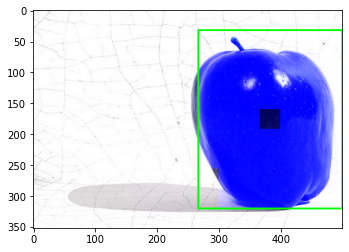

[]
save the 0th image. 
['0.jpg']


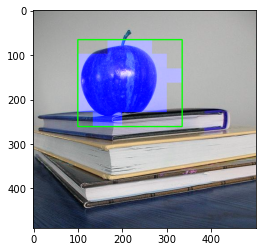

['0.jpg']
save the 1th image. 
['0.jpg', '1.jpg']


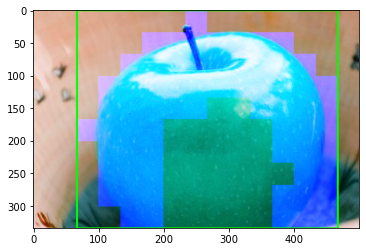

['0.jpg', '1.jpg']
save the 2th image. 
['0.jpg', '2.jpg', '1.jpg']


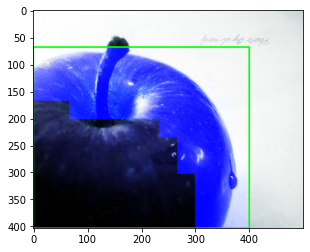

['0.jpg', '2.jpg', '1.jpg']
save the 3th image. 
['3.jpg', '0.jpg', '2.jpg', '1.jpg']


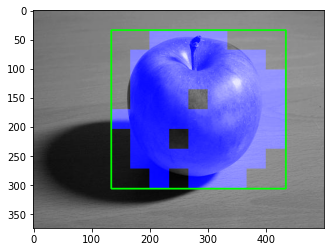

['3.jpg', '0.jpg', '2.jpg', '1.jpg']
save the 4th image. 
['3.jpg', '0.jpg', '2.jpg', '1.jpg', '4.jpg']


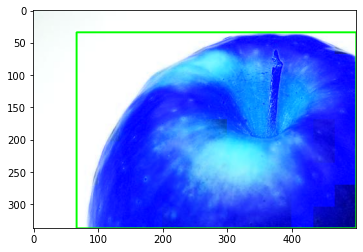

['3.jpg', '0.jpg', '2.jpg', '1.jpg', '4.jpg']
save the 5th image. 
['3.jpg', '0.jpg', '5.jpg', '2.jpg', '1.jpg', '4.jpg']


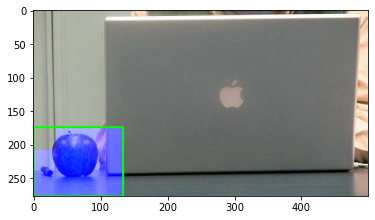

['3.jpg', '0.jpg', '5.jpg', '2.jpg', '1.jpg', '4.jpg']
save the 6th image. 
['6.jpg', '3.jpg', '0.jpg', '5.jpg', '2.jpg', '1.jpg', '4.jpg']


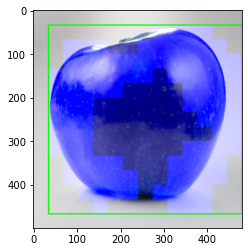

['6.jpg', '3.jpg', '0.jpg', '5.jpg', '2.jpg', '1.jpg', '4.jpg']
save the 7th image. 
['6.jpg', '3.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '1.jpg', '4.jpg']


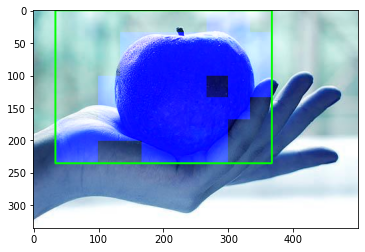

['6.jpg', '3.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '1.jpg', '4.jpg']
save the 8th image. 
['6.jpg', '3.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '1.jpg', '4.jpg']


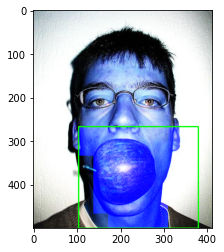

['6.jpg', '3.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '1.jpg', '4.jpg']
save the 9th image. 
['6.jpg', '3.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg']


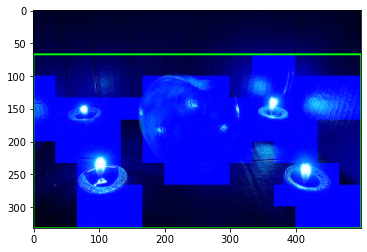

['6.jpg', '3.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg']
save the 10th image. 
['6.jpg', '3.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg', '10.jpg']


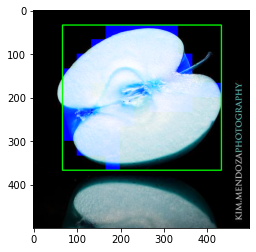

['6.jpg', '3.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg', '10.jpg']
save the 11th image. 
['6.jpg', '3.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg', '10.jpg']


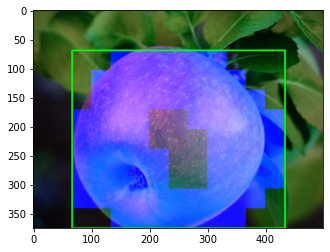

['6.jpg', '3.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg', '10.jpg']
save the 12th image. 
['6.jpg', '3.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg', '10.jpg']


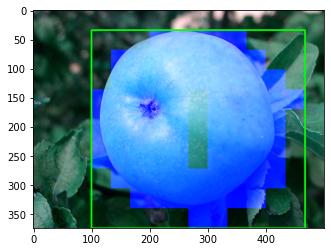

['6.jpg', '3.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg', '10.jpg']
save the 13th image. 
['13.jpg', '6.jpg', '3.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg', '10.jpg']


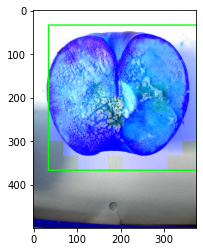

['13.jpg', '6.jpg', '3.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg', '10.jpg']
save the 14th image. 
['13.jpg', '6.jpg', '14.jpg', '3.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg', '10.jpg']


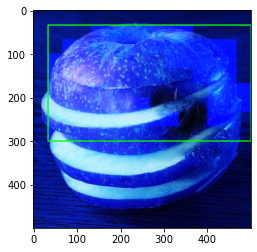

['13.jpg', '6.jpg', '14.jpg', '3.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg', '10.jpg']
save the 15th image. 
['13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg', '10.jpg']


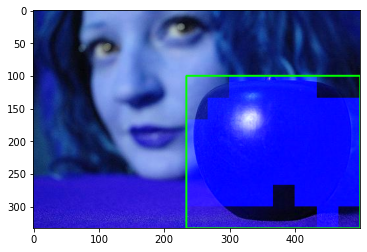

['13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '4.jpg', '10.jpg']
save the 16th image. 
['13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']


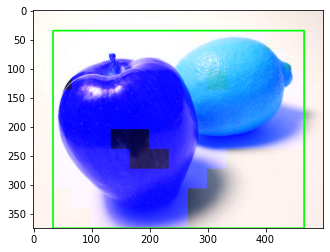

['13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']
save the 17th image. 
['13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']


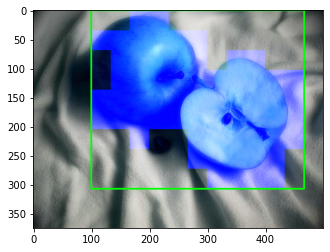

['13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '2.jpg', '8.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']
save the 18th image. 
['13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']


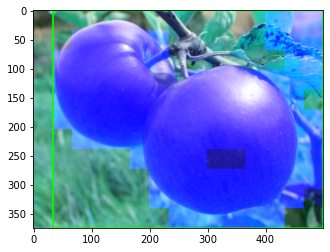

['13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']
save the 19th image. 
['13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']


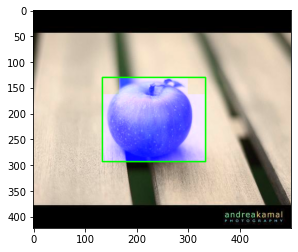

['13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']
save the 20th image. 
['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']


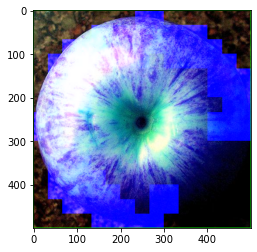

['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']
save the 21th image. 
['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '21.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']


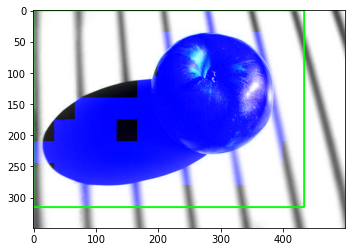

['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '21.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']
save the 22th image. 
['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '21.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']


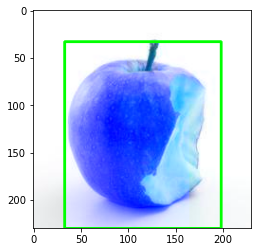

['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '21.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '4.jpg', '10.jpg']
save the 23th image. 
['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '21.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '23.jpg', '4.jpg', '10.jpg']


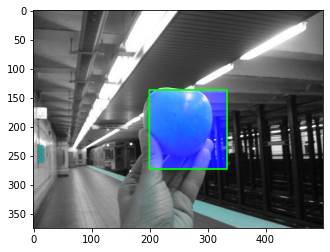

['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '21.jpg', '9.jpg', '17.jpg', '1.jpg', '16.jpg', '23.jpg', '4.jpg', '10.jpg']
save the 24th image. 
['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '21.jpg', '9.jpg', '17.jpg', '1.jpg', '24.jpg', '16.jpg', '23.jpg', '4.jpg', '10.jpg']


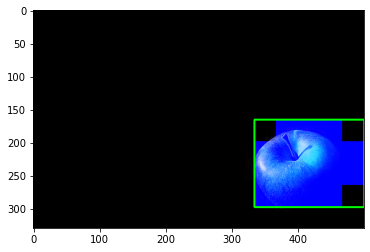

['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '21.jpg', '9.jpg', '17.jpg', '1.jpg', '24.jpg', '16.jpg', '23.jpg', '4.jpg', '10.jpg']
save the 25th image. 
['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '21.jpg', '9.jpg', '17.jpg', '1.jpg', '24.jpg', '16.jpg', '23.jpg', '4.jpg', '10.jpg', '25.jpg']


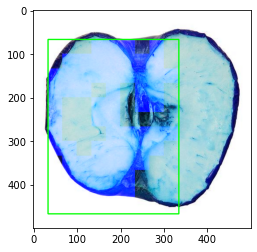

['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '21.jpg', '9.jpg', '17.jpg', '1.jpg', '24.jpg', '16.jpg', '23.jpg', '4.jpg', '10.jpg', '25.jpg']
save the 26th image. 
['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '26.jpg', '21.jpg', '9.jpg', '17.jpg', '1.jpg', '24.jpg', '16.jpg', '23.jpg', '4.jpg', '10.jpg', '25.jpg']


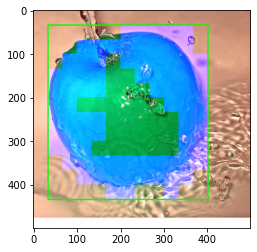

['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '26.jpg', '21.jpg', '9.jpg', '17.jpg', '1.jpg', '24.jpg', '16.jpg', '23.jpg', '4.jpg', '10.jpg', '25.jpg']
save the 27th image. 
['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '17.jpg', '1.jpg', '24.jpg', '16.jpg', '23.jpg', '4.jpg', '10.jpg', '25.jpg']


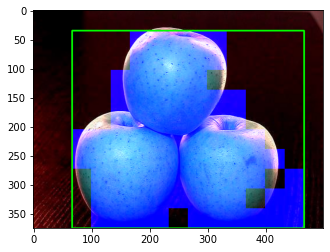

['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '17.jpg', '1.jpg', '24.jpg', '16.jpg', '23.jpg', '4.jpg', '10.jpg', '25.jpg']
save the 28th image. 
['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '4.jpg', '10.jpg', '25.jpg']


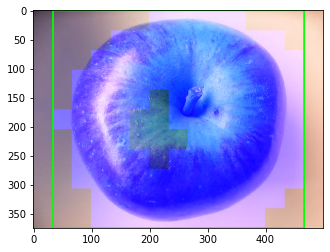

['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '4.jpg', '10.jpg', '25.jpg']
save the 29th image. 
['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '10.jpg', '25.jpg']


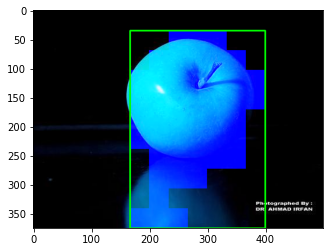

['20.jpg', '13.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '10.jpg', '25.jpg']
save the 30th image. 
['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '10.jpg', '25.jpg']


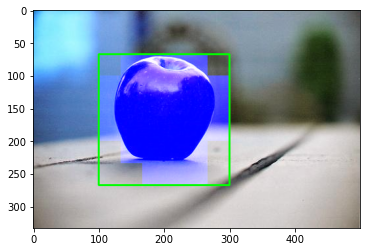

['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '10.jpg', '25.jpg']
save the 31th image. 
['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '10.jpg', '25.jpg']


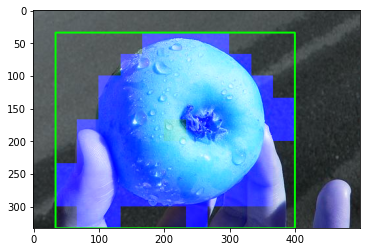

['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '10.jpg', '25.jpg']
save the 32th image. 
['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '10.jpg', '25.jpg']


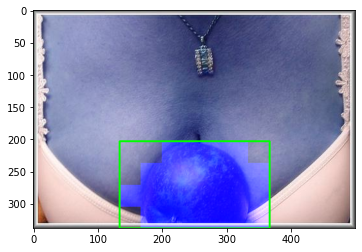

['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '10.jpg', '25.jpg']
save the 33th image. 
['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '25.jpg']


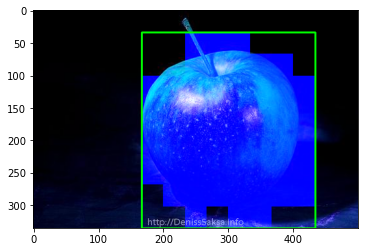

['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '25.jpg']
save the 34th image. 
['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '34.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '25.jpg']


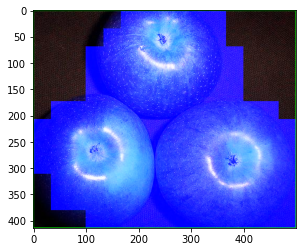

['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '34.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '25.jpg']
save the 35th image. 
['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '35.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '34.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '25.jpg']


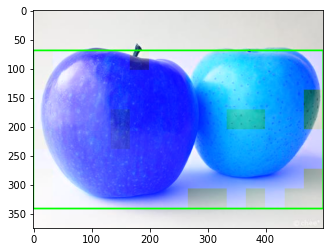

['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '35.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '34.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '25.jpg']
save the 36th image. 
['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '35.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '34.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '36.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '25.jpg']


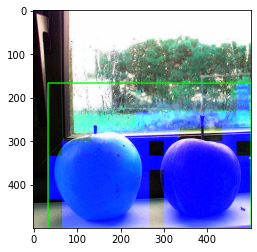

['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '35.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '34.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '36.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '25.jpg']
save the 37th image. 
['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '35.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '34.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '36.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '37.jpg', '25.jpg']


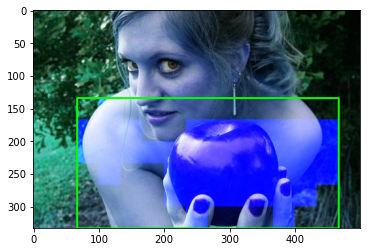

['20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '35.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '34.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '36.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '37.jpg', '25.jpg']
save the 38th image. 
['38.jpg', '20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '35.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '34.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '36.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '37.jpg', '25.jpg']


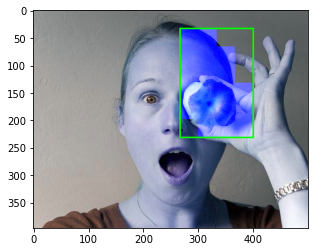

['38.jpg', '20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '35.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '34.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '36.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '37.jpg', '25.jpg']
save the 39th image. 
['38.jpg', '39.jpg', '20.jpg', '13.jpg', '30.jpg', '6.jpg', '14.jpg', '3.jpg', '35.jpg', '15.jpg', '12.jpg', '11.jpg', '0.jpg', '7.jpg', '34.jpg', '19.jpg', '22.jpg', '5.jpg', '18.jpg', '36.jpg', '2.jpg', '8.jpg', '32.jpg', '26.jpg', '21.jpg', '9.jpg', '27.jpg', '31.jpg', '17.jpg', '1.jpg', '28.jpg', '24.jpg', '16.jpg', '23.jpg', '29.jpg', '4.jpg', '33.jpg', '10.jpg', '37.jpg', '25.jpg']


In [165]:
ddt.co_locate(testdir, savedir, trans_vectors, descriptor_means)

In [166]:
savedir_plus = '/home/jakub/Studia/Semestr7/thesis/kod/Deep-Descriptor-Transforming-master/data/result/apple_plus'

In [167]:
ddt_plus = DDTplus(selected_layers=(34,36),use_cuda=False)
trans_vectors, descriptor_means = ddt_plus.fit(traindir)
ddt_plus.co_locate(testdir, savedir_plus, trans_vectors, descriptor_means)

use_cuda = False
processing 0th training images.
processing 1th training images.
processing 2th training images.
processing 3th training images.
processing 4th training images.
processing 5th training images.
processing 6th training images.
processing 7th training images.
processing 8th training images.
processing 9th training images.
processing 10th training images.
processing 11th training images.
processing 12th training images.
processing 13th training images.
processing 14th training images.
processing 15th training images.
processing 16th training images.
processing 17th training images.
processing 18th training images.
processing 19th training images.
processing 20th training images.
processing 21th training images.
processing 22th training images.
processing 23th training images.
processing 24th training images.
processing 25th training images.
processing 26th training images.
processing 27th training images.
processing 28th training images.
processing 29th training images.
pro

<ipython-input-63-f033b4d9a3b1>:128: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=4, use connectivity=1
  labels = measure.label(highlight, neighbors=4, background=0)


save the 0th image. 
save the 1th image. 
save the 2th image. 
save the 3th image. 
save the 4th image. 
save the 5th image. 
save the 6th image. 
save the 7th image. 
save the 8th image. 
save the 9th image. 
save the 10th image. 
save the 11th image. 
save the 12th image. 
save the 13th image. 
save the 14th image. 
save the 15th image. 
save the 16th image. 
save the 17th image. 
save the 18th image. 
save the 19th image. 
save the 20th image. 
save the 21th image. 
save the 22th image. 
save the 23th image. 
save the 24th image. 
save the 25th image. 
save the 26th image. 
save the 27th image. 
save the 28th image. 
save the 29th image. 
save the 30th image. 
save the 31th image. 
save the 32th image. 
save the 33th image. 
save the 34th image. 
save the 35th image. 
save the 36th image. 
save the 37th image. 
save the 38th image. 
save the 39th image. 


In [75]:
model = models.vgg19(pretrained=True).features

In [76]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

AttributeError: 'NoneType' object has no attribute 'shape'

In [92]:
import os
import cv2
from Rescale import Rescale
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os.path as osp

In [155]:
class ImageSet(Dataset):
    def __init__(self, folder_path, resize=None):
        files = os.listdir(folder_path)
        self.images = []
        for file in files:
            if not os.path.isdir(file) and file.split('.')[-1] == 'jpg':
                tmp_image = cv2.imread(osp.join(folder_path,file))
                self.images.append(tmp_image)

        if resize is not None:
            rescaler = Rescale(resize)
            for i in range(len(self.images)):
                self.images[i] = rescaler(self.images[i])

    def __getitem__(self, index):
        return self.images[index]

    def __len__(self):
        return len(self.images)


In [156]:
img0 = cv2.imread('/home/jakub/Studia/Semestr7/thesis/kod/Data/CoSal2015/Image/apple/apple_001.jpg')
img1 = cv2.imread('/home/jakub/Studia/Semestr7/thesis/kod/Data/CoSal2015/Image/apple/apple_002.jpg')
rescale = Rescale(224)
img0, img1 = rescale(img0), rescale(img1)

In [157]:
traindir

'/home/jakub/Studia/Semestr7/thesis/kod/Data/CoSal2015/Image/apple'

In [158]:
train_dataset = ImageSet(traindir, resize=1000)

In [159]:
train_dataset = ImageSet(traindir)

In [160]:
files = os.listdir(traindir)


In [161]:
files[0].split('.')[-1]

'jpg'

In [162]:
len(train_dataset)

40

In [153]:
for file in files:
    if not os.path.isdir(file) and file.split('.')[-1] == 'jpg':
        print(file)

apple_003.jpg
apple_039.jpg
apple_001.jpg
apple_022.jpg
apple_034.jpg
apple_012.jpg
apple_004.jpg
apple_007.jpg
apple_038.jpg
apple_008.jpg
apple_027.jpg
apple_026.jpg
apple_010.jpg
apple_030.jpg
apple_011.jpg
apple_023.jpg
apple_006.jpg
apple_040.jpg
apple_031.jpg
apple_005.jpg
apple_029.jpg
apple_018.jpg
apple_028.jpg
apple_002.jpg
apple_017.jpg
apple_009.jpg
apple_020.jpg
apple_037.jpg
apple_036.jpg
apple_016.jpg
apple_013.jpg
apple_015.jpg
apple_025.jpg
apple_019.jpg
apple_032.jpg
apple_021.jpg
apple_033.jpg
apple_014.jpg
apple_035.jpg
apple_024.jpg


In [154]:
for file in files:
    if not os.path.isdir(file):
        print(file)

apple_003.jpg
apple_039.jpg
apple_001.jpg
apple_022.jpg
apple_034.jpg
apple_012.jpg
apple_004.jpg
apple_007.jpg
apple_038.jpg
apple_008.jpg
apple_027.jpg
apple_026.jpg
apple_010.jpg
apple_030.jpg
Thumbs.db
apple_011.jpg
apple_023.jpg
apple_006.jpg
apple_040.jpg
apple_031.jpg
apple_005.jpg
apple_029.jpg
apple_018.jpg
apple_028.jpg
apple_002.jpg
apple_017.jpg
apple_009.jpg
apple_020.jpg
apple_037.jpg
apple_036.jpg
apple_016.jpg
apple_013.jpg
apple_015.jpg
apple_025.jpg
apple_019.jpg
apple_032.jpg
apple_021.jpg
apple_033.jpg
apple_014.jpg
apple_035.jpg
apple_024.jpg
